<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBMRegressor" data-toc-modified-id="LightGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBMRegressor</a></span></li><li><span><a href="#XGBRegressor" data-toc-modified-id="XGBRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>XGBRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install pandas-profiling[notebook]

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
#from pandas_profiling import ProfileReport
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [3]:
df = pd.read_csv('/datasets/taxi.csv')

In [4]:
profile = ProfileReport(df, title="Pandas Profiling Report taxi.scv")

In [5]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Меняем тип столбца со строки на datetime64 

In [6]:
df['datetime'] = df['datetime'].astype('datetime64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Устанавливаем и сортируем индекс таблицы равным столбцу Datetime.

In [7]:
df = df.set_index('datetime')

In [8]:
df.sort_index(inplace=True)
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Для проверки временной последовательности распределения данных применztv функцию исследования монотонности. Видим, что данные последовательны во времени. 

In [9]:
df.index.is_monotonic

True

Поменяем интервал временного ряда ресемплированием(перегруппировкой) целевого признака с 10 минут на 1 час.

In [10]:
df_resampled = df.resample('1H').sum()
df_resampled = df_resampled.sort_index(ascending=True)
df_resampled

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


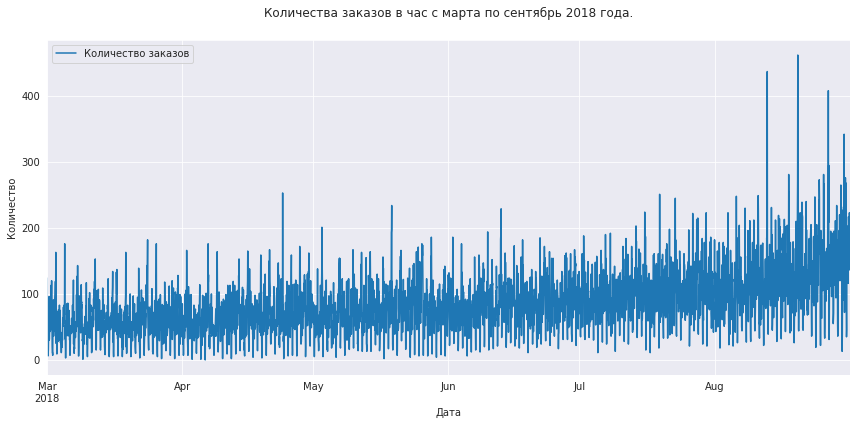

In [11]:
sns.set_style('darkgrid')
df_resampled.plot(ax=plt.gca(),figsize=(12,6))
plt.legend(['Количество заказов'])
plt.title('Количества заказов в час с марта по сентябрь 2018 года.', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

На графике видно, что с марта август включительно среднее количество заказов растёт.

## Анализ

Чтобы во временном ряду снизить колебания, применим скользящее среднее.

**Скользящее среднее (англ. rolling mean)**, или движущееся среднее (англ. moving average), — метод сглаживания временных рядов. Его суть заключается в поиске значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.

Чтобы лучше понимать временной ряд, так же посмотрим тренд и сезонность.

**Тренд (англ. trend)** — плавное изменение среднего значения ряда без повторяющихся закономерностей. Например в нащем случае, ежемесячное увеличение объёма заказов такси.

**Сезонность (англ. seasonality)** — циклично повторяющиеся закономерности во временном ряду. Допустим, рост продаж авиабилетов летом.

Тренды и сезонность зависят от масштаба данных. В нашем случае мы можем увидеть закономерности, повторяющиеся каждые сутки, неделю или месяц, так как у нас есть  есть данные только за полгода. 

Используем функцию seasonal_decompose() (англ. «разбить на части»), чтобы разложить временной ряд на три составляющие: тренд, сезонность и остаток (англ. residuals - компонента, которая не объясняется трендом и сезонностью, это шум)

In [12]:
decomposed = seasonal_decompose(df_resampled)

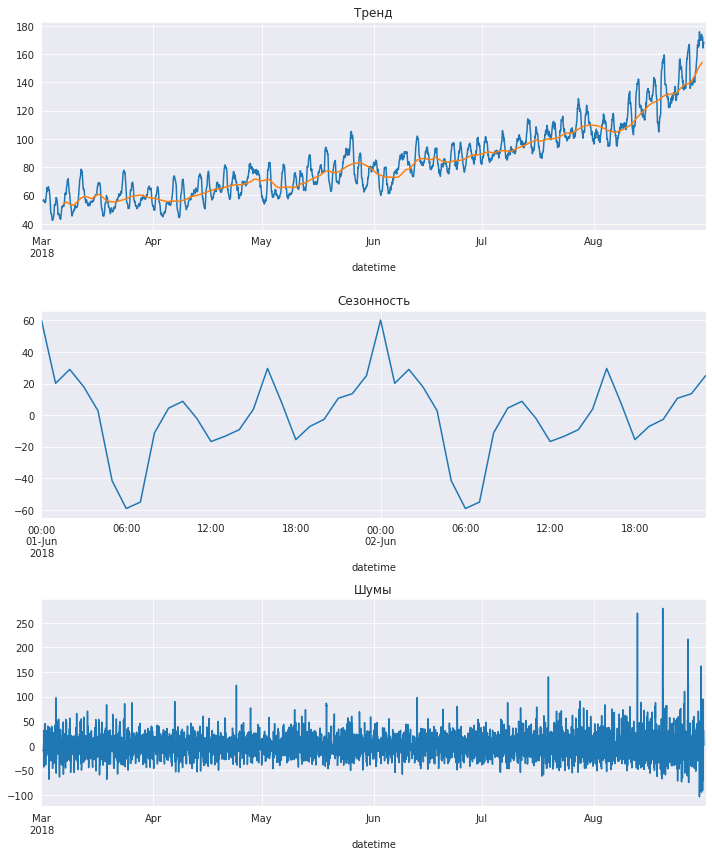

In [13]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
decomposed.trend.resample('1D').mean().rolling(7).mean().plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-06-01':'2018-06-02'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шумы')
plt.tight_layout()

- Явно выраженный ежемесячный тренд роста количества заказов начиная с марта 2018 года.
- На временном отрезке в сутки видим суточную сезонность, утором количество заказов резко падает, потом до 10 утра опять растет(люди едут на работу в школу и тп), потмо следующий пик числа заказов виден в конце рабочего дня ~17-00, к 18-00 количество заказов падает а потом опять начинает резко расти до полуночи. 




Проверим стационарность временного ряда. Стационарный ряд в отличие от нестационарного лучше поддается прогнозированию. 

Чтобы выяснить какой временной ряд найдем разности временного ряда (англ. time series difference) — это набор разностей между соседними элементами временного ряда, т. е. из каждого значения вычитается предыдущее. Для поиска разностей временного ряда применяется метод shift() (англ. «сдвиг»). Все значения он сдвигает вдоль временной оси на один шаг вперёд. **Стационарные временные ряды (англ. stationary time series) — это ряды, у которых среднее и стандартное отклонение не меняются**. Полученный результат визуализируем.

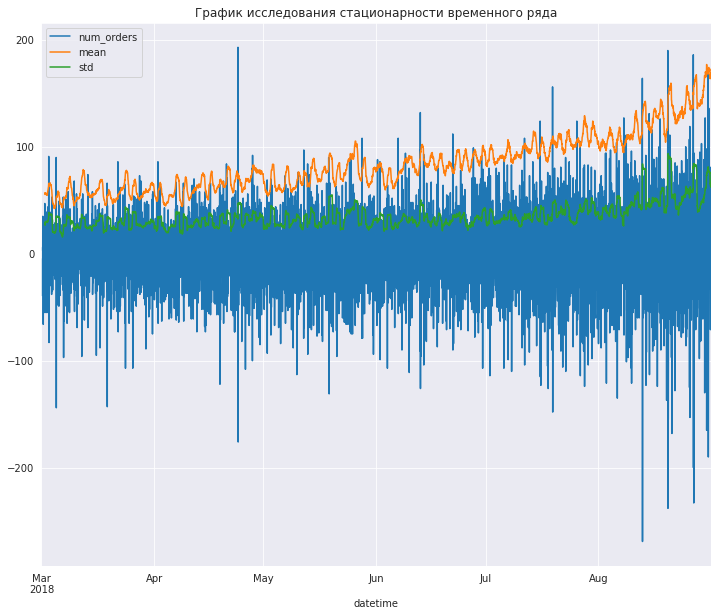

In [14]:
df_shift = df_resampled - df_resampled.shift()
df_shift['mean'] = df_resampled['num_orders'].rolling(24).mean()
df_shift['std'] = df_resampled['num_orders'].rolling(24).std()
df_shift.plot(figsize=(12,10))
plt.title('График исследования стационарности временного ряда')
plt.show()

- Визуально ряд стационарен,так как его среднее значение и стандартное отклонение не сильно меняются. Датасет можно смело использовать в прогнозировании. 

Формируем нулевую и альтернативную гипотезу о  стационарности ряда. По результататм статитстического теста Дики-Фуллера гипотезы будут приняты либо отвергнуты.

 - Нулевая гипотеза (H0): Если не удалось отклонить, он предполагает, что временной ряд имеет единичный корень, то есть он нестационарный. Он имеет некоторую временную структуру.
 
- Альтернативная гипотеза (H1): Нулевая гипотеза отвергается; он предполагает, что временной ряд не имеет единичного корня, то есть он является стационарным. Он не имеет временной структуры.



In [15]:
df_test_result = adfuller(df['num_orders'])
                        
print('ADF Statistic: {}'.format(df_test_result[0]))
print('p-value: {}'.format(df_test_result[1]))
print('Critical values:')
for key, value in df_test_result[4].items():
    print('\t {}: {}'.format(key, value))
if df_test_result[0] < df_test_result[4]["5%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")    

ADF Statistic: -12.548885000267546
p-value: 2.2286378815479297e-23
Critical values:
	 1%: -3.430597284562216
	 5%: -2.861649292553069
	 10%: -2.566828173184574
Нулевая гипотеза отвергнута – Временной ряд стационарен


**Интерпретация теста**

Для понимания, является ряд стационарным или нет, необходимо сравнить значение ADF статистики с критическими значениями и p-value c с уровнем значимости.

 - 1)При выполнении теста тестовое статистическое значение ADF -12,55. Чем более отрицательна эта статистика, тем больше вероятность того, что мы отвергнем нулевую гипотезу (у нас есть стационарный набор данных).
        Как часть выходных данных, мы получаем справочную таблицу, чтобы помочь определить статистику ADF. Мы можем видеть, что наше статистическое значение -12.55 меньше, чем -3.43 при 1%, -2,86 при 5%, -2.56 при 10%. Это говорит о том, что мы можем отклонить нулевую гипотезу с уровнем значимости менее 5% (т.e. Низкая вероятность того, что в результате получится статистическая случайность).
 

 - 2)Мы так же интерпретируем этот результат, используя значение p-value из теста. Значение p-value ниже порогового значения (обычно это 0,05) предполагает, что мы отвергаем нулевую гипотезу (стационарную), в противном случае значение p-value выше порогового значения указывает на то, что мы не можем отклонить нулевую гипотезу (нестационарную).
       р-значение > 0,05: Не удается отклонить нулевую гипотезу (H0), данные имеют единичный корень и являются нестационарными.
       р-значение < = 0,05: Отклонить нулевую гипотезу (H0), данные не имеют единичного корня и являются стационарными.

## Обучение

Напишем функцию для создания новых признаков, необходимых нам для прогнозирования.Это будут:
- календарные признаки.Возьму месяц и день недели, тк эти данные на мой взгляд более могут быть связаны с сезонностью.
- отстающие значения, чтобы предыдущие значения временного ряда показали нам, будет ли функция x(t) расти или уменьшаться. 
- Скользящее среднее как признак задающий общий тренд временного ряда. 

In [16]:
def make_features(data, target, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[target].shift(lag)
    data['rolling_mean'] = data[target].shift().rolling(rolling_mean_size).mean()

Добавим 24 столбца отстающих значений и один столбец скользящего среднего значения с окном в сутки(24 часа)

In [17]:
make_features(df_resampled,'num_orders',24,24)

In [18]:
df_resampled.head()

,num_orders,month,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим данные на обучающую и тестовую выборки в соотношении 90%/10%. Так как параметры мы будем искать с помощью кросс-валидации через GridSearchCV валидационная выборка нам не нужна.
Для прогнозирования буду использовать и модели по списку.

In [19]:
train, test = train_test_split(df_resampled, shuffle =False, test_size = 0.1)
print('Тренировочная выборка- {:.0%}'.format(train.shape[0]/df_resampled.shape[0]))
print('Тестовая выборка - {:.0%}'.format(test.shape[0]/df_resampled.shape[0]))

train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']


Тренировочная выборка- 90%
Тестовая выборка - 10%


Проведем масштабирование числовых признаков при помощи StandartScaler. Обучать scaler будем только на выборке train, так как иначе это может привести к утечке данных (data leak).

In [20]:
scaler = StandardScaler()

scaler.fit(features_train)
scaled_features_train = features_train.copy()
scaled_features_test = features_test.copy()

scaled_features_train = scaler.transform(features_train)
scaled_features_test = scaler.transform(features_test)


In [21]:
results_df=pd.DataFrame()

Создал функцию результатов, в которой реализовано наполнение датафрейма results_df общих результатов по моделям. Время обучения и предсказания взял из cv_results_, а RMSE из best_score_

In [22]:
def results(model):
    global results_df
    # лучшее значение RMSE на кросс-валидации
    best_score=model.best_score_*-1
    print(f'best_score RMSE: {round(best_score,2)}')
    
   
   
    # лучшие гиперпараметры
    print(f'best_params: {model.best_params_}')
    best_params_index=model.cv_results_['params'].index(model.best_params_)
    best_fit_time = round(model.cv_results_['mean_fit_time'][best_params_index],2)
    best_score_time = round(model.cv_results_['mean_score_time'][best_params_index],2)
   
    print('best fit time, sec.:',best_fit_time)
    print('best score time, sec.:',best_score_time)
    
    estimator=model.estimator.__class__.__name__
    model_result=pd.DataFrame({'Model':[estimator],'RMSE':[best_score],'Fit_Time':[best_fit_time],'Score_time':[best_score_time]})
    results_df=pd.concat([results_df,model_result],ignore_index=True)
    
    return results_df

Приступаем к обучению моделей, поиску наилучших гиперпараметров и выводу результатов.

### RandomForest

Для временных рядов есть свои методы кросс-валидации, например, TimeSeriesSplit, используем его.

In [23]:
tscv = TimeSeriesSplit(n_splits=3)

In [24]:
RFR = RandomForestRegressor(bootstrap=True,random_state=12345)
parameters = {'max_depth': [x for x in range (3,13,3)],
              'n_estimators': [x for x in range(100,151,50)],
             }

grid_RFR = GridSearchCV(RFR,parameters,cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1,verbose=2)
grid_RFR = grid_RFR.fit(scaled_features_train,target_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.4s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ......................max_depth=3, n_estimators=100; total time=   0.9s
[CV] END ......................max_depth=3, n_estimators=150; total time=   0.6s
[CV] END ......................max_depth=3, n_estimators=150; total time=   0.9s
[CV] END ......................max_depth=3, n_estimators=150; total time=   1.4s
[CV] END ......................max_depth=6, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=6, n_estimators=100; total time=   1.2s
[CV] END ......................max_depth=6, n_estimators=100; total time=   1.8s
[CV] END ......................max_depth=6, n_estimators=150; total time=   1.0s
[CV] END ......................max_depth=6, n_estimators=150; total time=   1.8s
[CV] END ......................max_depth=6, n_est

In [25]:
results(grid_RFR)

best_score RMSE: 27.54
best_params: {'max_depth': 12, 'n_estimators': 150}
best fit time, sec.: 3.22
best score time, sec.: 0.02


,Model,RMSE,Fit_Time,Score_time
0,RandomForestRegressor,27.5425,3.22,0.02


### CatBoost

In [26]:
CBR = CatBoostRegressor(loss_function='RMSE',silent=True,random_seed=12345)
CBR_params = {'learning_rate': np.logspace(-3, 0, 5),'iterations': range(20, 61, 20),'depth': range(3,13,3)}

grid_CBR = GridSearchCV(CBR, CBR_params, cv=tscv, scoring='neg_root_mean_squared_error',n_jobs = -1, verbose = 2)
grid_CBR.fit(scaled_features_train, target_train);

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END ........depth=3, iterations=20, learning_rate=0.001; total time=   0.9s
[CV] END ........depth=3, iterations=20, learning_rate=0.001; total time=   0.7s
[CV] END ........depth=3, iterations=20, learning_rate=0.001; total time=   0.7s
[CV] END depth=3, iterations=20, learning_rate=0.005623413251903491; total time=   0.7s
[CV] END depth=3, iterations=20, learning_rate=0.005623413251903491; total time=   0.6s
[CV] END depth=3, iterations=20, learning_rate=0.005623413251903491; total time=   0.7s
[CV] END depth=3, iterations=20, learning_rate=0.03162277660168379; total time=   0.7s
[CV] END depth=3, iterations=20, learning_rate=0.03162277660168379; total time=   0.7s
[CV] END depth=3, iterations=20, learning_rate=0.03162277660168379; total time=   0.8s
[CV] END depth=3, iterations=20, learning_rate=0.1778279410038923; total time=   0.7s
[CV] END depth=3, iterations=20, learning_rate=0.1778279410038923; total time=   0.7

In [27]:
results(grid_CBR)

best_score RMSE: 27.21
best_params: {'depth': 6, 'iterations': 60, 'learning_rate': 0.1778279410038923}
best fit time, sec.: 0.91
best score time, sec.: 0.01


,Model,RMSE,Fit_Time,Score_time
0,RandomForestRegressor,27.542500,3.22,0.02
1,CatBoostRegressor,27.211834,0.91,0.01


### LightGBMRegressor

In [28]:
LGBM = LGBMRegressor(boosting_type='gbdt',random_state=12345, learning_rate = 0.18, objective='rmse',force_col_wise=True)
LGBM_params ={'n_estimators': [40, 60], 'num_leaves': [31, 41, 51]}
grid_LGBM = GridSearchCV(LGBM, LGBM_params, cv=tscv, scoring='neg_root_mean_squared_error', verbose = 2)
grid_LGBM.fit(scaled_features_train, target_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .....................n_estimators=40, num_leaves=31; total time=  34.9s
[CV] END .....................n_estimators=40, num_leaves=31; total time=  49.6s
[CV] END .....................n_estimators=40, num_leaves=31; total time= 1.3min
[CV] END .....................n_estimators=40, num_leaves=41; total time= 1.2min
[CV] END .....................n_estimators=40, num_leaves=41; total time= 1.9min
[CV] END .....................n_estimators=40, num_leaves=41; total time= 2.6min
[CV] END .....................n_estimators=40, num_leaves=51; total time= 2.4min
[CV] END .....................n_estimators=40, num_leaves=51; total time=  17.8s
[CV] END .....................n_estimators=40, num_leaves=51; total time=  19.5s
[CV] END .....................n_estimators=60, num_leaves=31; total time=  14.5s
[CV] END .....................n_estimators=60, num_leaves=31; total time=  33.8s
[CV] END .....................n_estimators=60, nu

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(force_col_wise=True, learning_rate=0.18,
                                     objective='rmse', random_state=12345),
             param_grid={'n_estimators': [40, 60], 'num_leaves': [31, 41, 51]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [29]:
results(grid_LGBM)

best_score RMSE: 27.34
best_params: {'n_estimators': 40, 'num_leaves': 51}
best fit time, sec.: 59.98
best score time, sec.: 0.14


,Model,RMSE,Fit_Time,Score_time
0,RandomForestRegressor,27.542500,3.22,0.02
1,CatBoostRegressor,27.211834,0.91,0.01
2,LGBMRegressor,27.336115,59.98,0.14


### XGBRegressor

In [30]:
XGBR = XGBRegressor(booster='gbtree',random_state=12345, learning_rate = 0.18)
XGBR_params ={'n_estimators': [40, 60], 'max_depth': [3, 6, 9, 12]}
grid_XGBR = GridSearchCV(XGBR, XGBR_params, cv=tscv, scoring='neg_root_mean_squared_error', verbose = 2)
grid_XGBR.fit(scaled_features_train, target_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END .......................max_depth=3, n_estimators=40; total time=  21.4s
[CV] END .......................max_depth=3, n_estimators=40; total time=  25.9s
[CV] END .......................max_depth=3, n_estimators=40; total time=  19.7s
[CV] END .......................max_depth=3, n_estimators=60; total time=  31.9s
[CV] END .......................max_depth=3, n_estimators=60; total time=  47.7s
[CV] END .......................max_depth=3, n_estimators=60; total time= 1.0min
[CV] END .......................max_depth=6, n_estimators=40; total time= 1.4min
[CV] END .......................max_depth=6, n_estimators=40; total time= 1.9min
[CV] END .......................max_depth=6, n_estimators=40; total time= 1.6min
[CV] END .......................max_depth=6, n_estimators=60; total time=  44.6s
[CV] END .......................max_depth=6, n_estimators=60; total time=  58.7s
[CV] END .......................max_depth=6, n_es

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.18, max_delta_step=None,
                                    max_d...
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=12345, reg_alpha=None,
                                    re

In [31]:
results(grid_XGBR)

best_score RMSE: 27.4
best_params: {'max_depth': 3, 'n_estimators': 60}
best fit time, sec.: 47.1
best score time, sec.: 0.07


,Model,RMSE,Fit_Time,Score_time
0,RandomForestRegressor,27.542500,3.22,0.02
1,CatBoostRegressor,27.211834,0.91,0.01
2,LGBMRegressor,27.336115,59.98,0.14
3,XGBRegressor,27.400357,47.10,0.07


На обучающей выборке лучшая модель по качеству предсказания это CatBoostRegressor RMSE = 27.21, следом LGBMRegressor = 27.34, XGBRegressor = 27.40, RandomForestRegressor = 27.54.

## Тестирование

Создал процедуру для подсчета RMSE и вывода графиков предсказанных и целевых значений признака в установленном интервале времени.

In [32]:
def rmse(target,predict):
    pred_data= pd.Series(predict, index=features_test.index)
    pred_data[data1:data2].plot(ax=plt.gca(),figsize=(12,7))
    target_test[data1:data2].plot(ax=plt.gca(),figsize=(12,7))
    plt.legend(['num_orders,predict', 'num_orders,target'])
    plt.title(f'Предсказанное и целевое количество заказов по тестовой выборке\
    с {data1} по {data2}', y=1.05)

    plt.xlabel('Дата')
    plt.ylabel('Количество');
    print(f'RMSE --->',round(np.sqrt(np.mean((predict-target)**2)),2))

Для наглядности взял интервал в 1 сутки по дате в середине тестовой выборки.

In [33]:
data1 = '2018-08-20 00:00:00'
data2 = '2018-08-20 23:00:00'

### CatBoost

In [34]:
predict_CBR = grid_CBR.best_estimator_.predict(scaled_features_test)

RMSE ---> 43.22


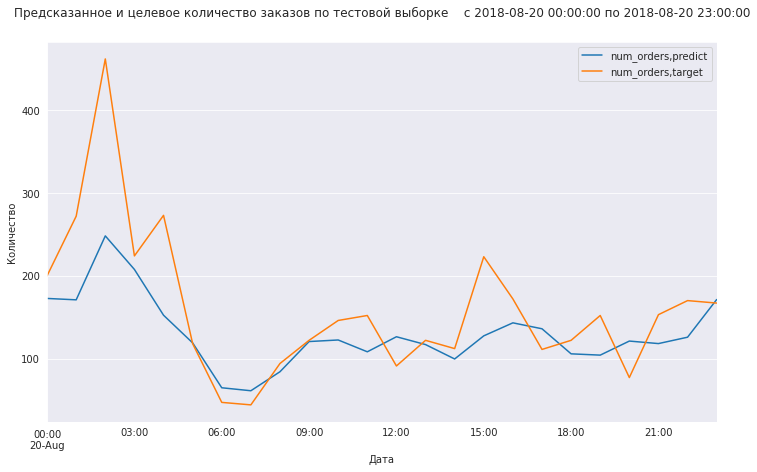

In [35]:
rmse(target_test,predict_CBR)

## Вывод

Перед нами стояла задача, на исторических данных о заказах такси в аэропортах построить модель, которая смогла бы прогнозировать количество заказов такси на следующий час, при этом значенние метрики 
 не должно быть больше 


Целью работы было исследовать модели для предсказания количества заказов такси на основе исходных данных по количеству заказов с привязкой к дате и времени.При этом необходимо было добиться значения RMSE не более 48. 

- В исходный датасет был изучен, ресемплирован с 10 минут до 1 часа, временной ряд изучен на стационарность. Явно выражен ежемесячный тренд роста количества заказов начиная с марта 2018 года.На временном отрезке в сутки видим суточную сезонность

- Для обучения моделей добавили в данные календарные признаки по месяцу даты события и дню недели. 24 столбца со сдвигом целевой метки и скользящее среднее значение с окном в 24 часа.

- На подготовленных данных были обучены и протестированы несколько моделей  RandomForestRegressor,CatBoostRegressor,LightGBM и XGBRegressor c подбором разных гиперпараметров.

В результате все модели на тренировочной выборке достигли лучше чем заданное значения метрики. Для предсказания на тестовой выюорке быда отобрана модель CatBoostRegressor, тк на обучении она показала наилучший результат.Значение метрики RMSE на тесте CatBoostRegressor = 43.22, что укладывается в заданные пераметры.